In [1]:
'''Change Log:
    11/22/19 TB - Added consistent time intervals between census tracts for use in MCMC 22
''';

In [2]:
# Import necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sn
import geopandas as gpd
import numpy as np
import pymc3 as pm
# import theano.tensor as tt
from datetime import datetime, timedelta

E-Bikes dropped: 338834
Original scooter entries: 6510117
NA rows dropped: 130
Out of Bounds entries dropped: 52981
Before removing outliers:


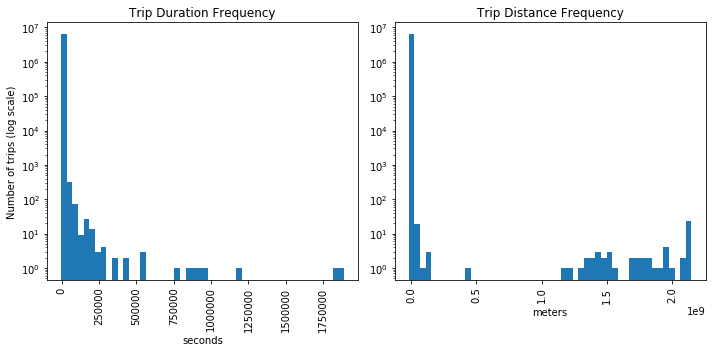

Negative duration dropped: 1028
Over 12.0 hours dropped: 262
Negative or 0 distance dropped: 505391
Distance > 49.9999845312 mi dropped: 965
After removing outliers:


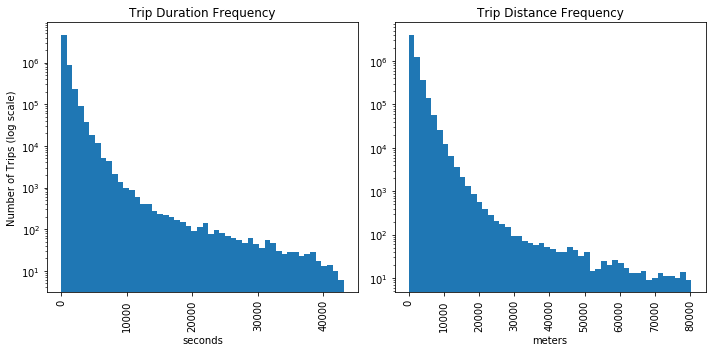

Total entries remaining: 5949360
Percent removed: 8.61362399477613%
Column Data types:
Device ID                           object
Vehicle Type                      category
Trip Duration                      float64
Trip Distance                      float64
Start Time                  datetime64[ns]
End Time                    datetime64[ns]
Modified Date               datetime64[ns]
Month                                 int8
Hour                                  int8
Day of Week                           int8
Council District (Start)           float64
Council District (End)             float64
Year                                 int16
Census Tract Start                  object
Census Tract End                    object
dtype: object


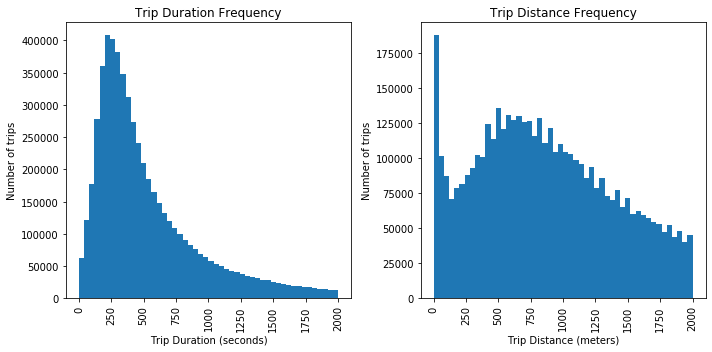

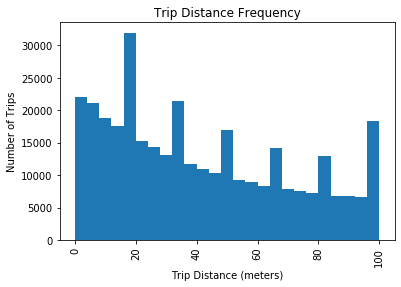

Number of Census Tract Starts: 256
Number of Census Tract Ends: 257
Number of unique Census Tracts in the data: 271


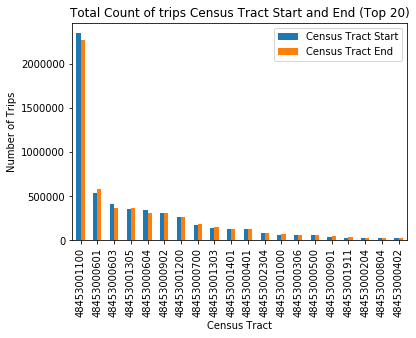

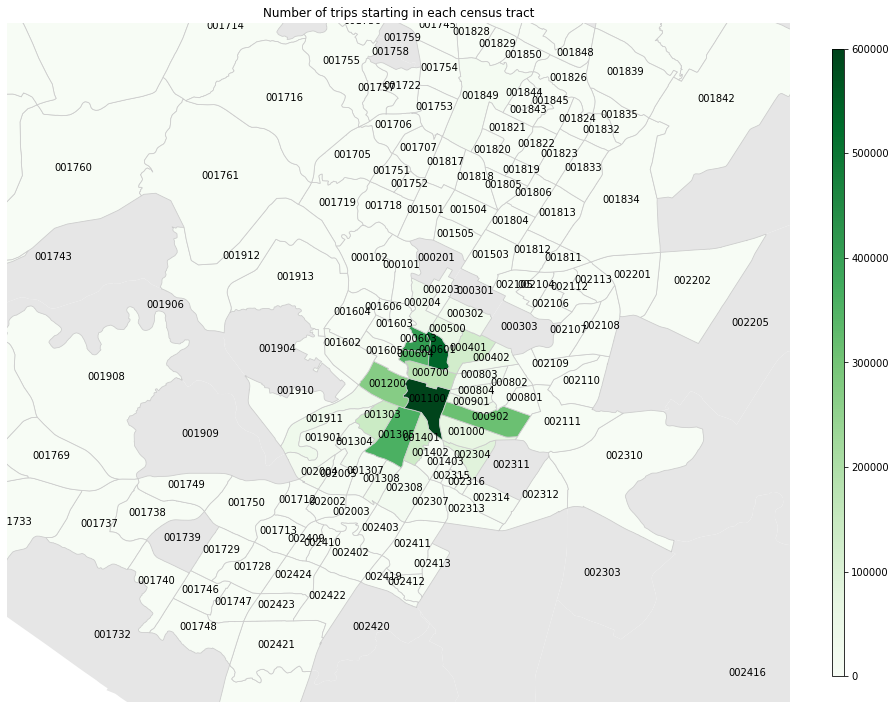

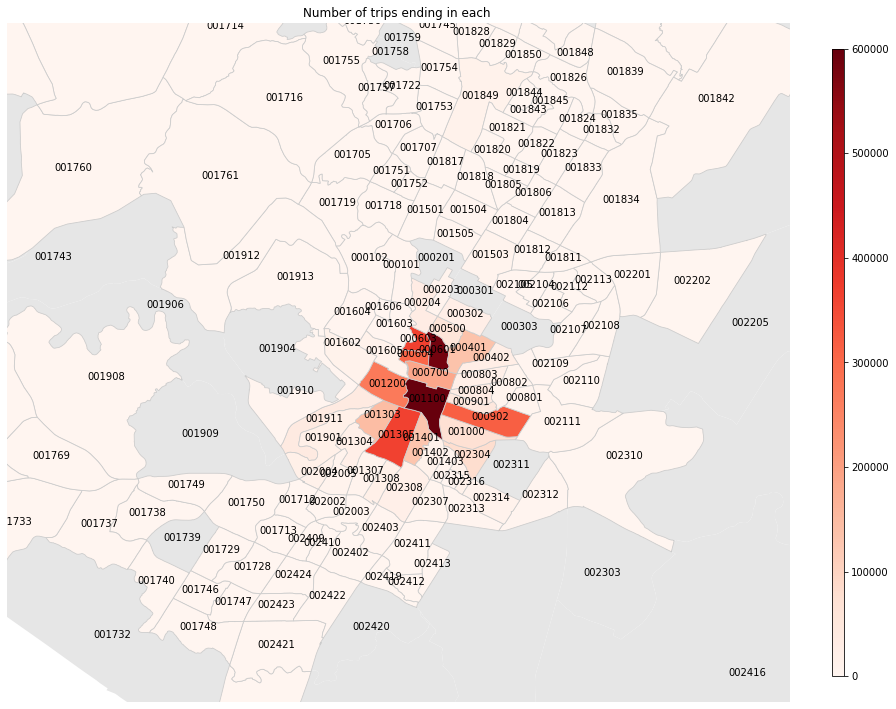

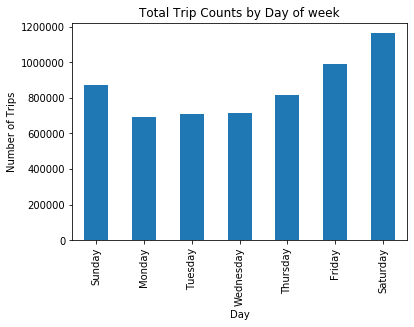

Top 4 starting location counts by day:


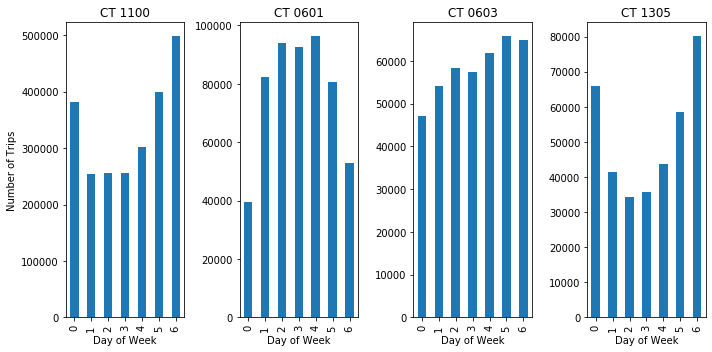

Top 4 ending location counts by day:


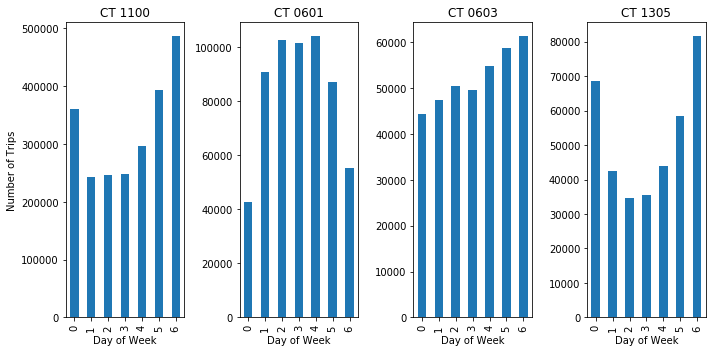

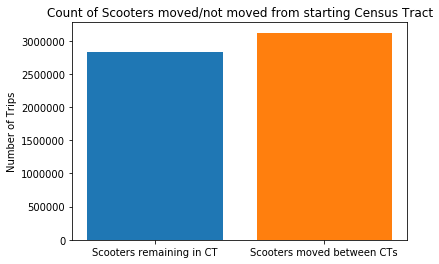

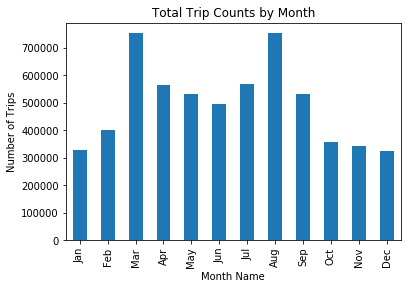

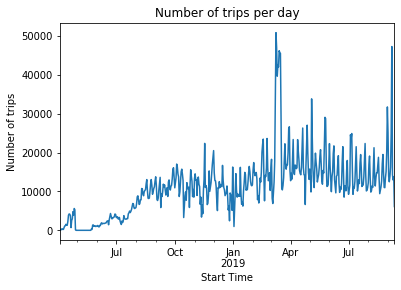

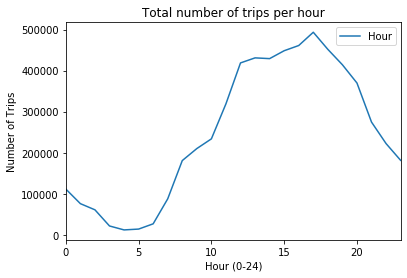

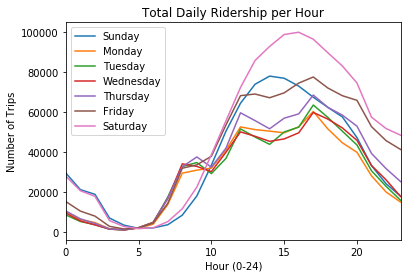

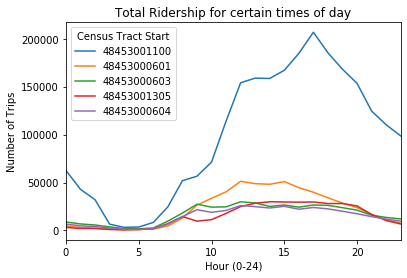

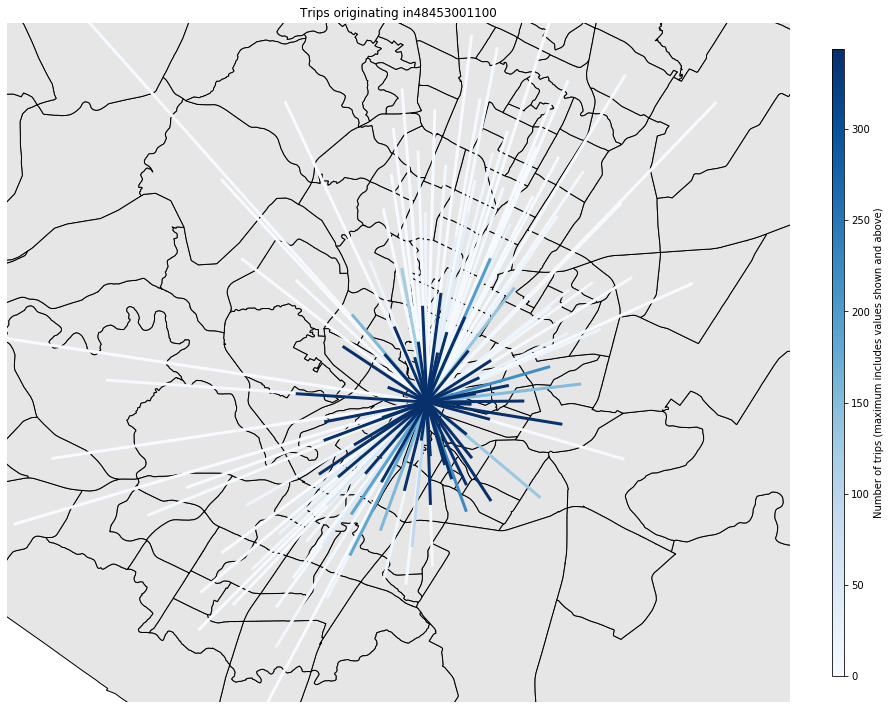

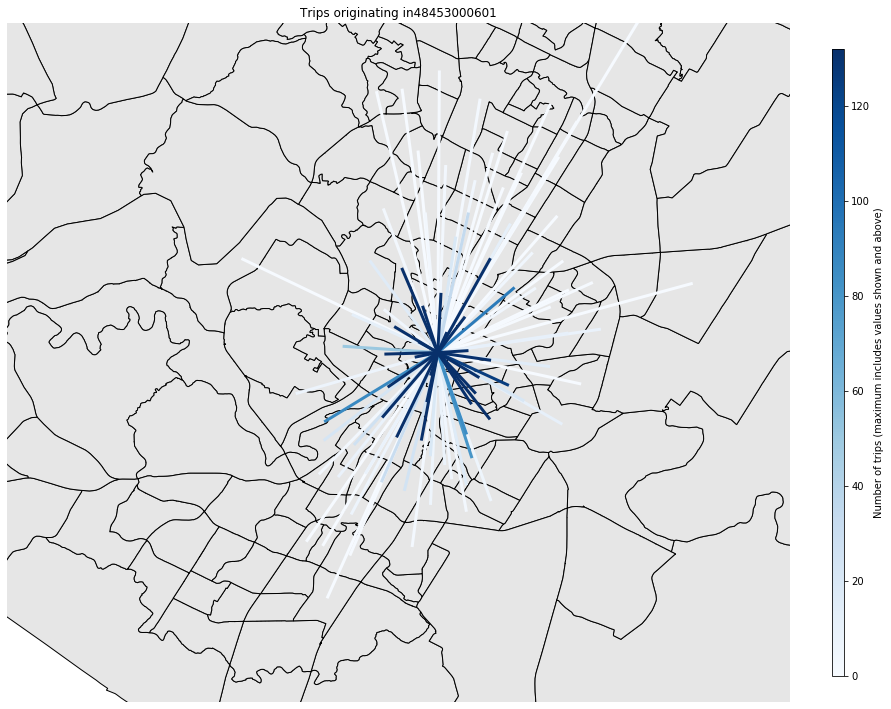

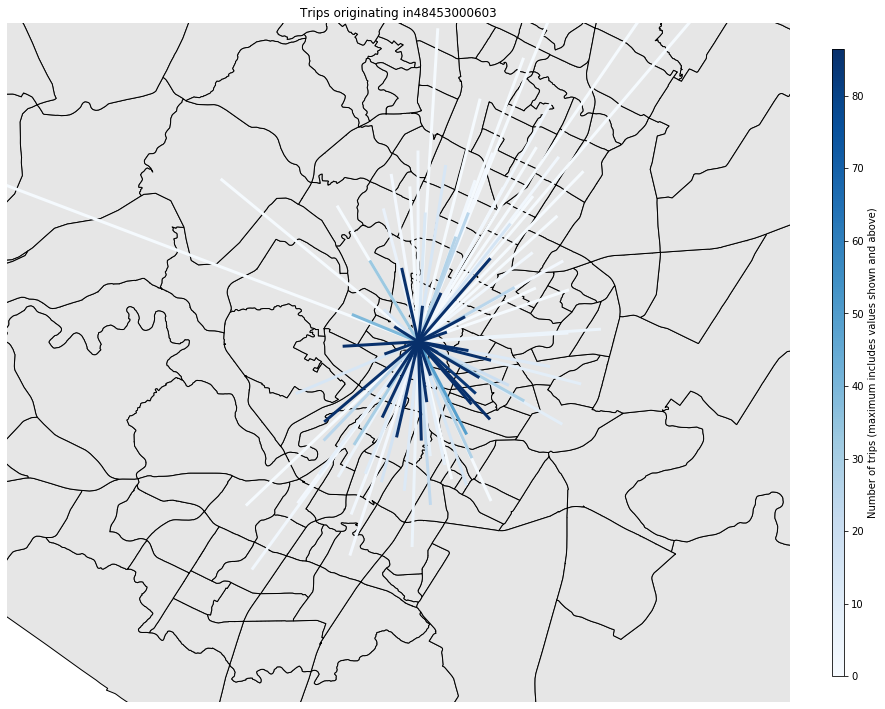

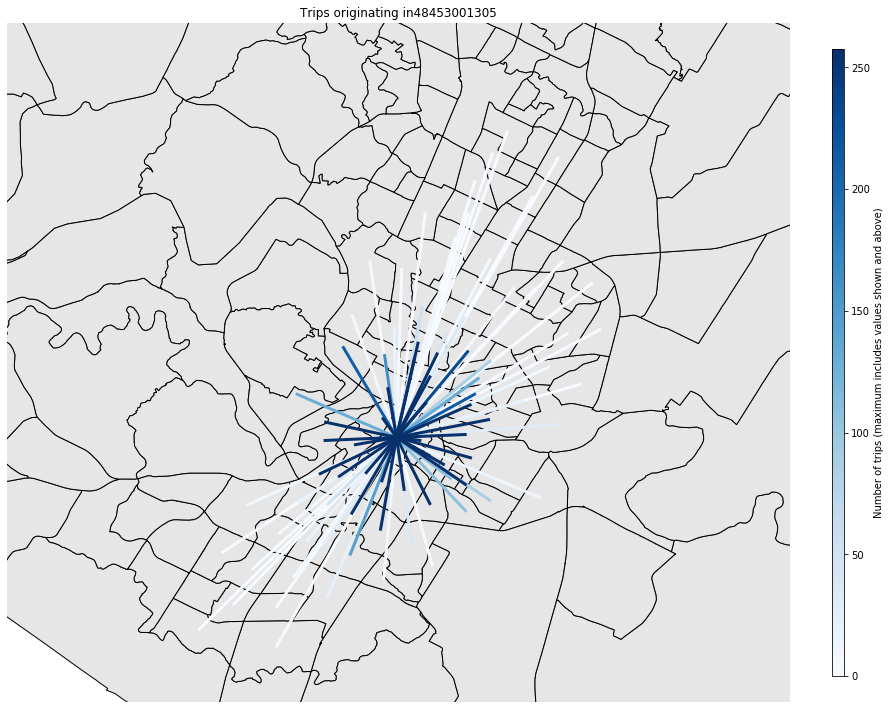

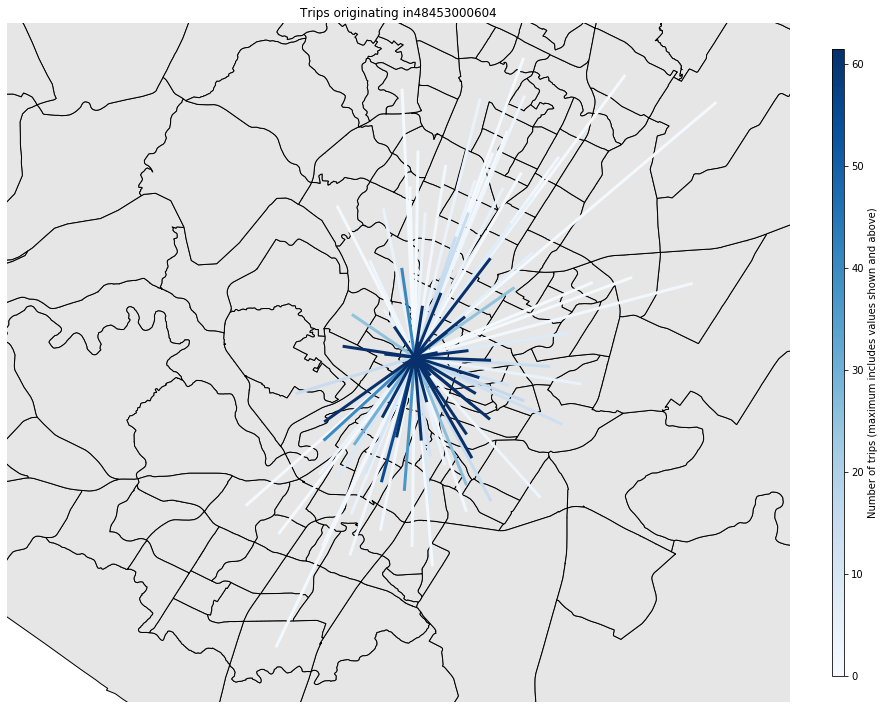

In [3]:
# Run the data_story notebook to bring in the modified scooters dataframe
%run ./data_story.ipynb

In [4]:
# Revisit the number of trips per day question from section 9, let's look at individual Census Tracts

def trip_calendar(census_tract, tau=None, lambdas=None):
    '''Plots daily trip count across timeframe of data
    Parameters:
        census_tract_start: str, full census tract number'''

    # set up axes for subplots
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
    
    # filter and resample for desired census tract
    trips = scooters[scooters['Census Tract Start'] == census_tract].resample('D', on='Start Time').count()
    
    # Plot results (arbitrarily using Device ID because using the count method)
    ax1.set(ylabel='Number of trips', title='Number of trips per day in ' + census_tract)
    trips['Device ID'].plot(ax=ax1)
   
    # plot tau if specified
    if tau is not None:
        ax1.axvline(x=tau, color='r', linewidth=2, linestyle='-')      
    
    
    #Plot a basemap
    map_df.plot(color='0.9', edgecolor='0.0', ax=ax2)
    ax2.axis('off')
    ax2.set(title='Location of ' + census_tract)
    
    # Plot the location of this ct
    map_df[map_df['CTIDFP00'] == census_tract].plot(color='g', ax=ax2)
    
    # Bound the map
    bbox = (-97.919881, -97.589348, 30.139918,30.426626)
    plt.xlim(bbox[0], bbox[1])
    plt.ylim(bbox[2], bbox[3])
 
    plt.tight_layout()
    plt.show()
    return fig, (ax1, ax2)



Over time, increased in most of the census tracts.  Assuming that each CT can be modeled by a Poisson distribution that changes at $\tau$ and has parameters $\lambda_1$ and $\lambda_2$.
$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

Also assume that both $\lambda$ are distributed on an exponential function with parameter $\alpha$

In [5]:
# create a count dataframe for a given census tract
def ct_daily_count(census_tract):
    trips = scooters[scooters['Census Tract Start'] == census_tract].resample('D', on='Start Time').count()
    trips = trips['Device ID']
    
    # Fill the time before the start of the series (to ensure consistent time intervals across CTs)
    if trips.index[0] > pd.to_datetime(scooters['Start Time'].min()):
        
        # create a filler series of 0s
        pre_fill_index = pd.date_range(start=scooters['Start Time'].min(), 
                                       end=trips.index[0]- timedelta(days=1), 
                                       freq='D')
        pre_fill = pd.Series(np.zeros_like(pre_fill_index, dtype='int64'), 
                             index=pre_fill_index)
        
        # concatenate filler series to 0s
        trips = pre_fill.append(trips)
    
    # Fill the time after the end of the series (to ensure consistent time intervals across CTs)
    if trips.index[-1] < pd.to_datetime(scooters['Start Time'].max()):
        
        # create a filler of 0s
        post_fill_index = pd.date_range(start=trips.index[-1] + timedelta(days=1), 
                                        end = scooters['Start Time'].max(), 
                                        freq='D')
        post_fill = pd.Series(np.zeros_like(post_fill_index, dtype='int64'), 
                              index=post_fill_index)
        
        trips = trips.append(post_fill)
        
    return trips

In [6]:
def poisson_model(census_tract):
    
    # bring in dataframe of counts for the given census tract
    ct_daily = ct_daily_count(census_tract)
    sample_size = 50000
    
    with pm.Model() as ct_model:
        # Define alpha (upon which the exponentials for lambda are based)
        alpha = 1.0/ct_daily.mean()

        #Define Stochastic variables, lambdas
        lambda_1 = pm.Exponential('lambda_1', alpha)
        lambda_2 = pm.Exponential('lambda_2', alpha)

        # Define Stochastic variable tau
        tau = pm.DiscreteUniform('tau', lower=0, upper=len(ct_daily) - 1)

        # Create a switch to tell the model to look for a tau when the model changes
        idx = np.arange(len(ct_daily))
        lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

        # Create an observation from the Poisson Distribution
        observation = pm.Poisson('observation', lambda_, observed=ct_daily)

        # Create a sample
        step = pm.Metropolis()
        trace = pm.sample(sample_size, step=step)
    
    # remove burn in values
    burn_size = np.int64(sample_size/2)  
    trace_burned = trace[burn_size:]
    
    return trace_burned

In [7]:
# plot posteriors
def poisson_and_plot_cts(census_tract):
    
    # Run the MCMC Poisson 
    trace = poisson_model(census_tract)
    
    # Plot the Posterier
    pm.plots.plot_posterior(trace, 
                            var_names= ['lambda_1', 'lambda_2', 'tau'], 
                            credible_interval=0.95, 
                            kind='hist')

    # find datetime equivalent of tau
    tau_datetime = ct_daily_count(census_tract).reset_index().iloc[0,0] + timedelta(days=np.mean(trace['tau']))

    # find lambda/tau values
    lambda_1_mean = np.mean(trace['lambda_1'])
    lambda_2_mean = np.mean(trace['lambda_2'])
    tau_mean = np.mean(trace['tau'])
    
    # plot current trip
    fig, (ax1, ax2) = trip_calendar(census_tract, tau=tau_datetime, lambdas=[lambda_1_mean, lambda_2_mean])
    
    return trace, lambda_1_mean, lambda_2_mean, tau_mean

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:32<00:00, 3120.47draws/s]
The number of effective samples is smaller than 10% for some parameters.


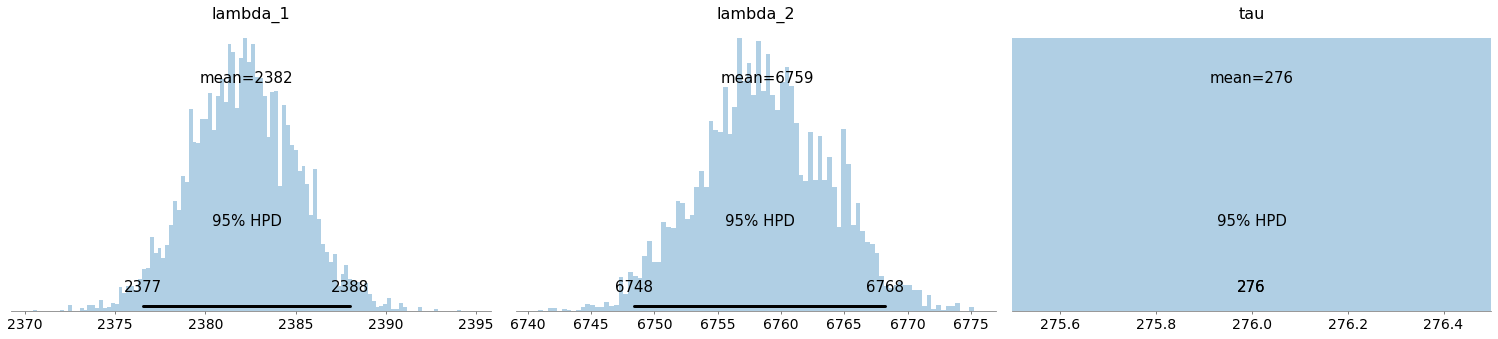

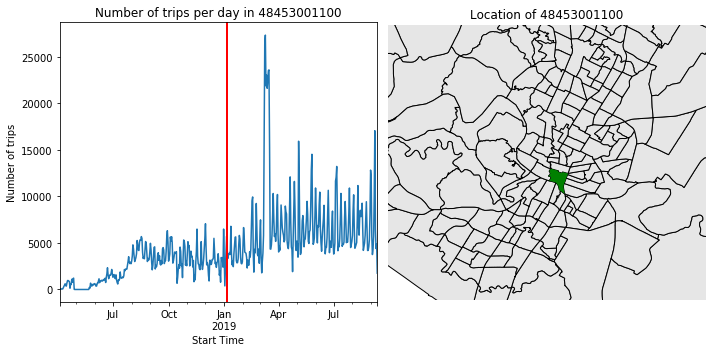

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:32<00:00, 3147.10draws/s]
The number of effective samples is smaller than 10% for some parameters.


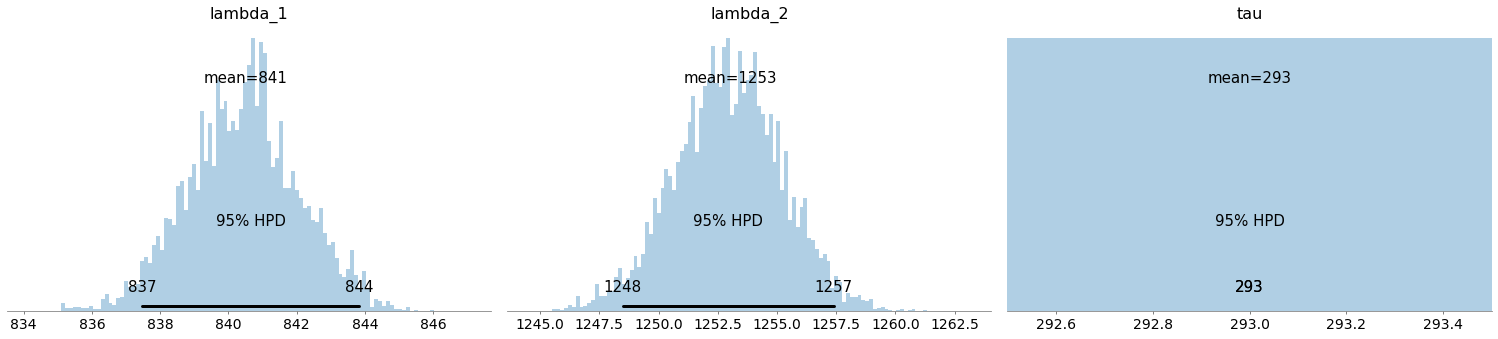

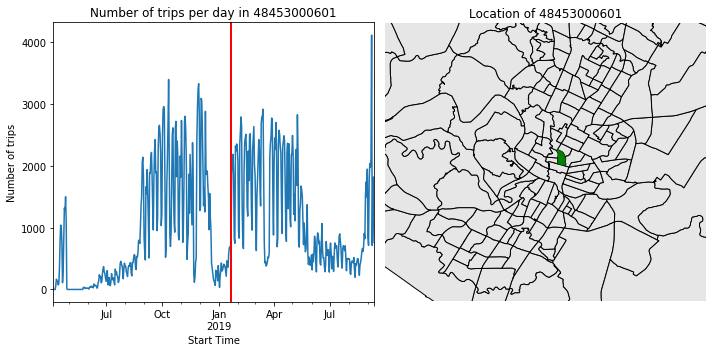

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:42<00:00, 2364.85draws/s]
The number of effective samples is smaller than 10% for some parameters.


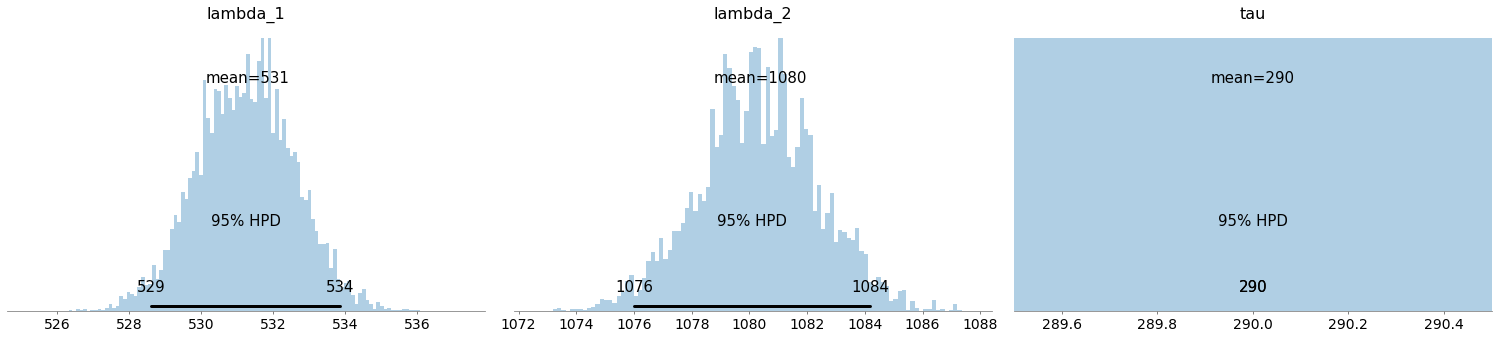

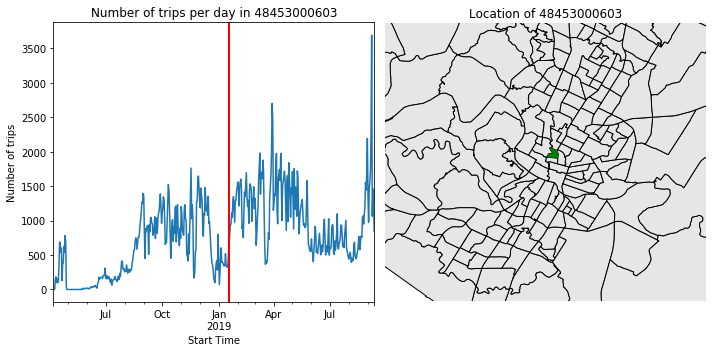

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:49<00:00, 2058.44draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


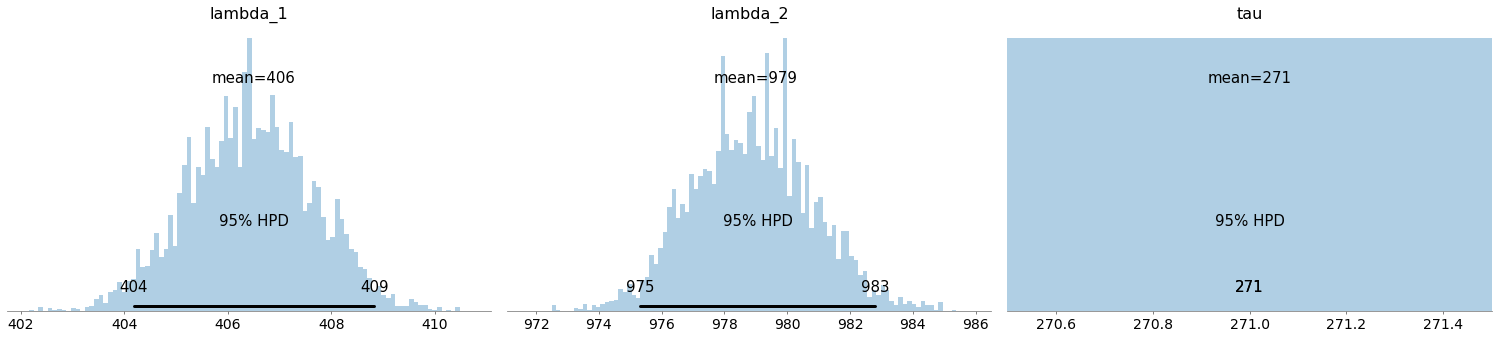

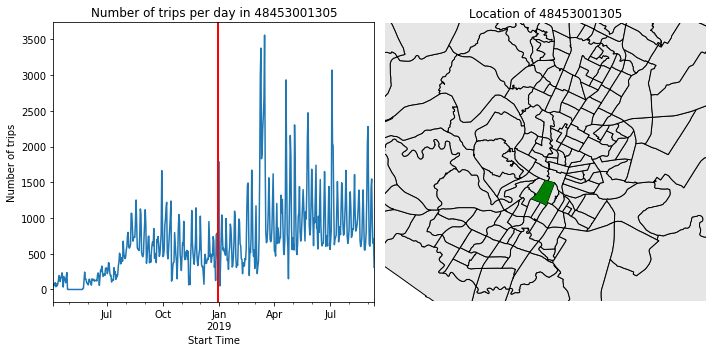

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:40<00:00, 2505.57draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


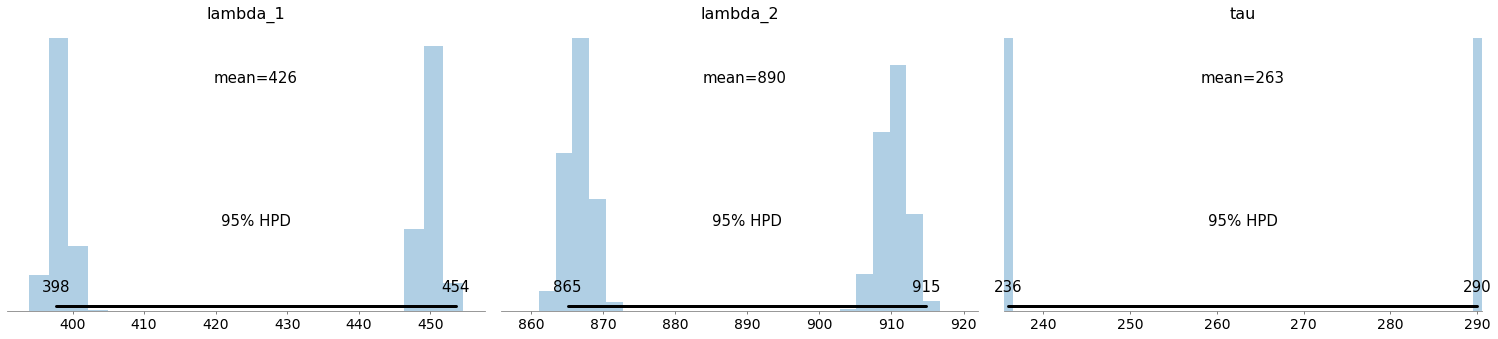

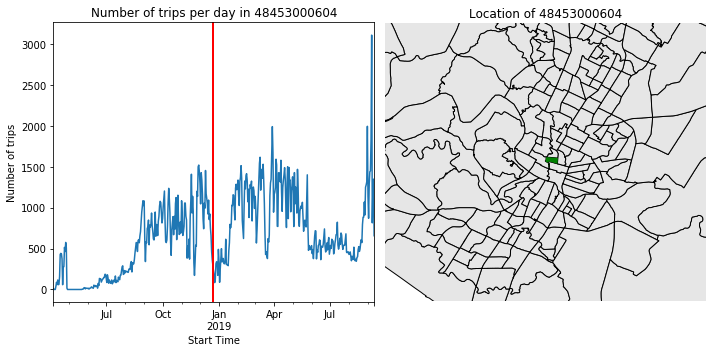

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:46<00:00, 2177.91draws/s]
The number of effective samples is smaller than 10% for some parameters.


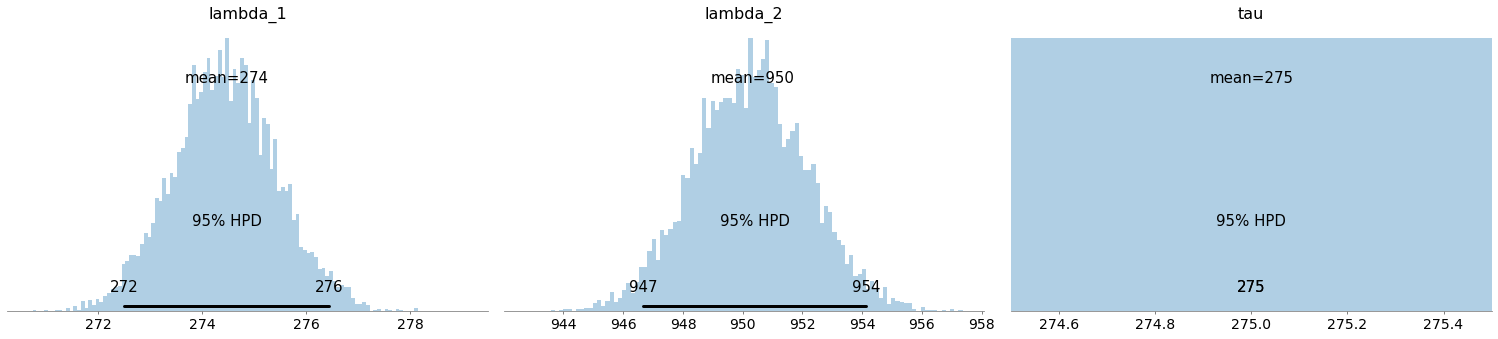

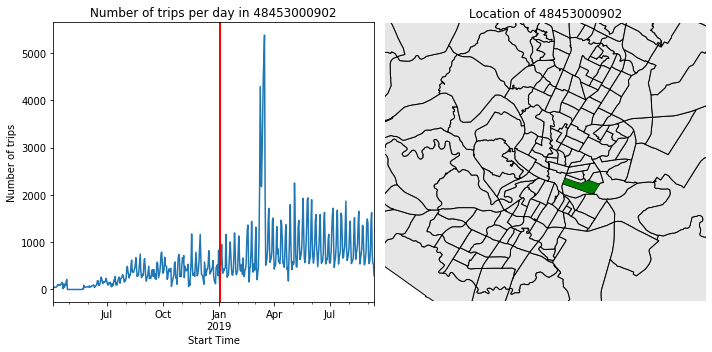

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:36<00:00, 2753.17draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


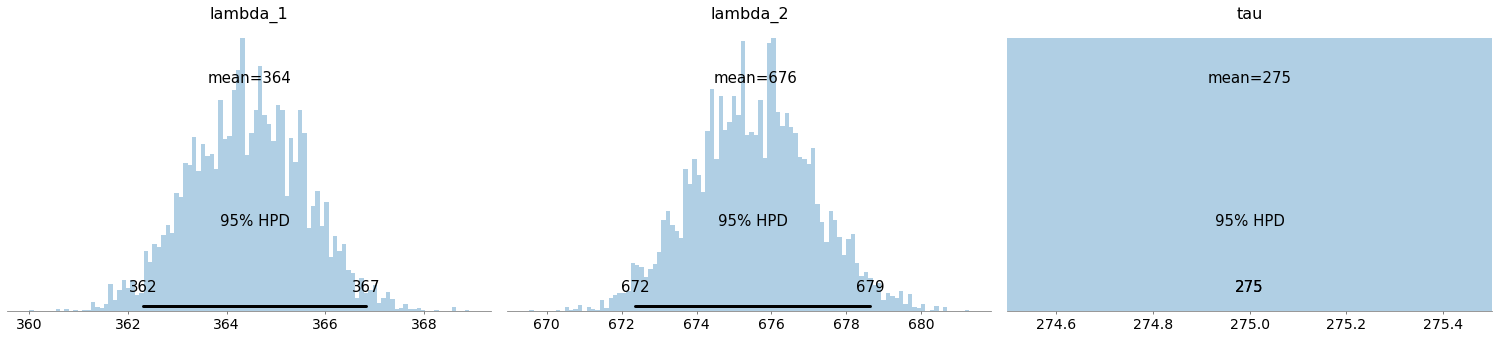

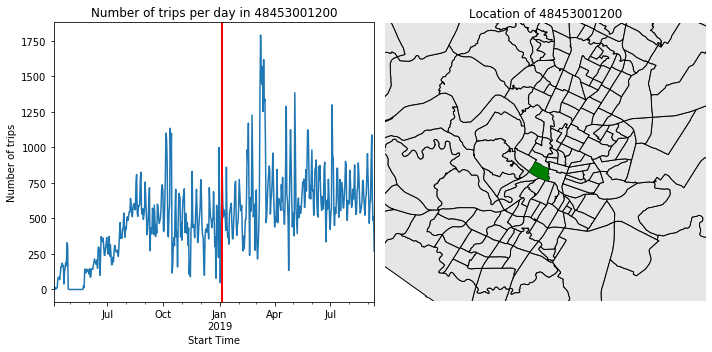

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:48<00:00, 2076.23draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


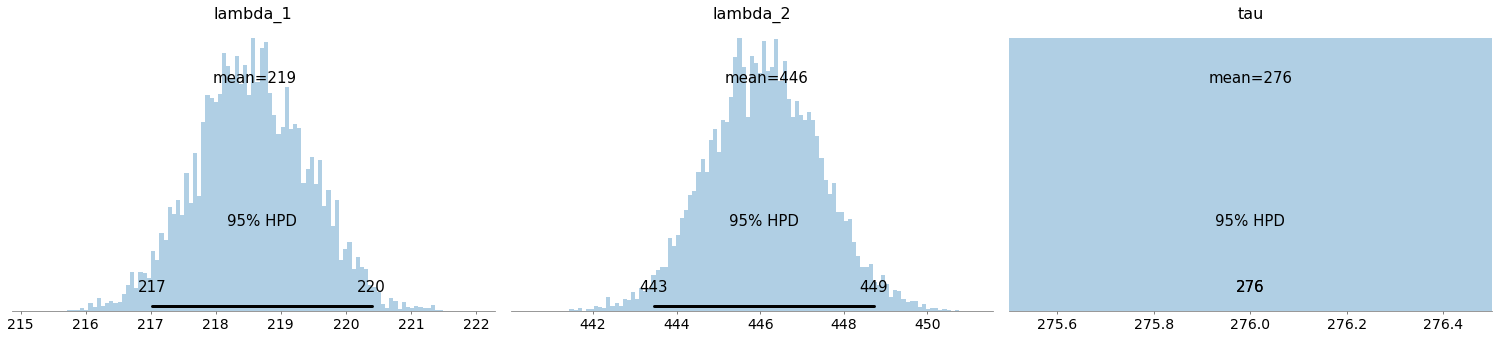

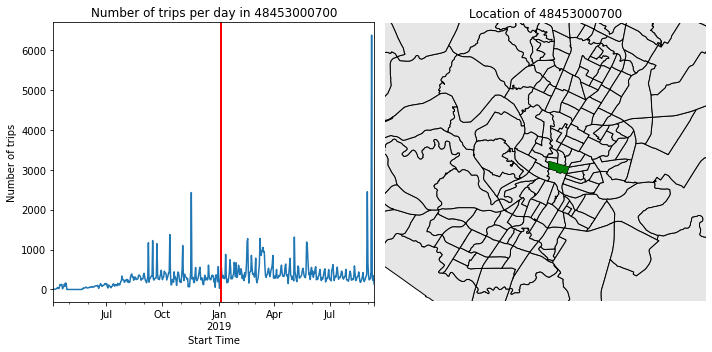

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:42<00:00, 2348.87draws/s]
The number of effective samples is smaller than 10% for some parameters.


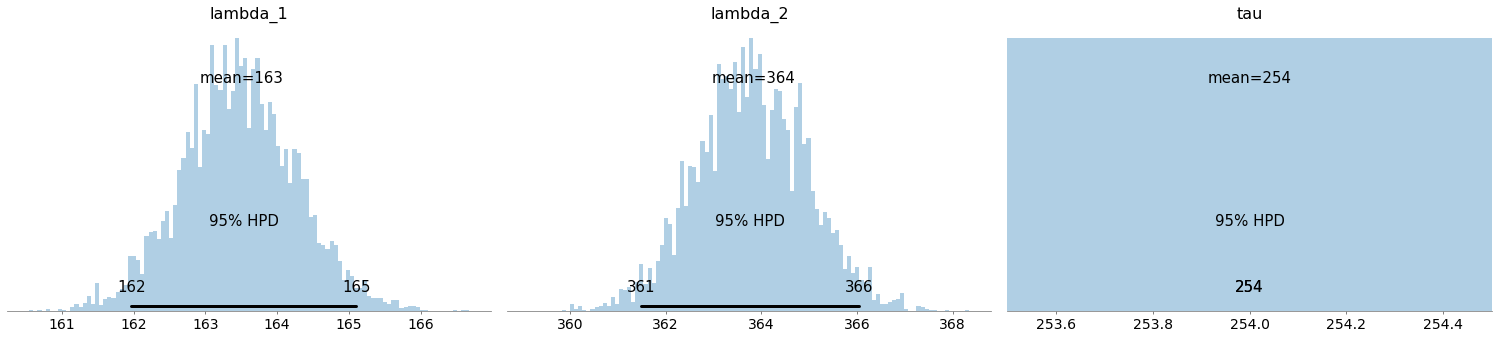

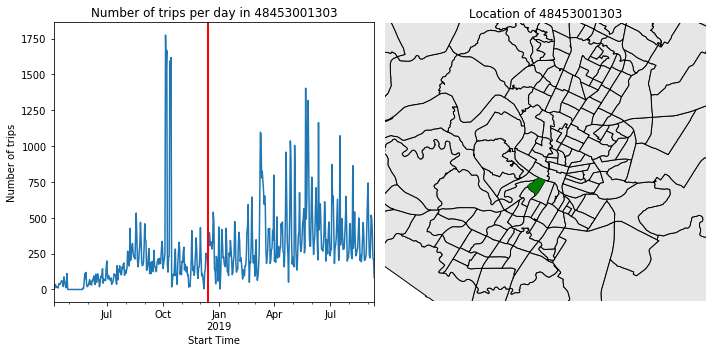

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:47<00:00, 2134.48draws/s]
The number of effective samples is smaller than 10% for some parameters.


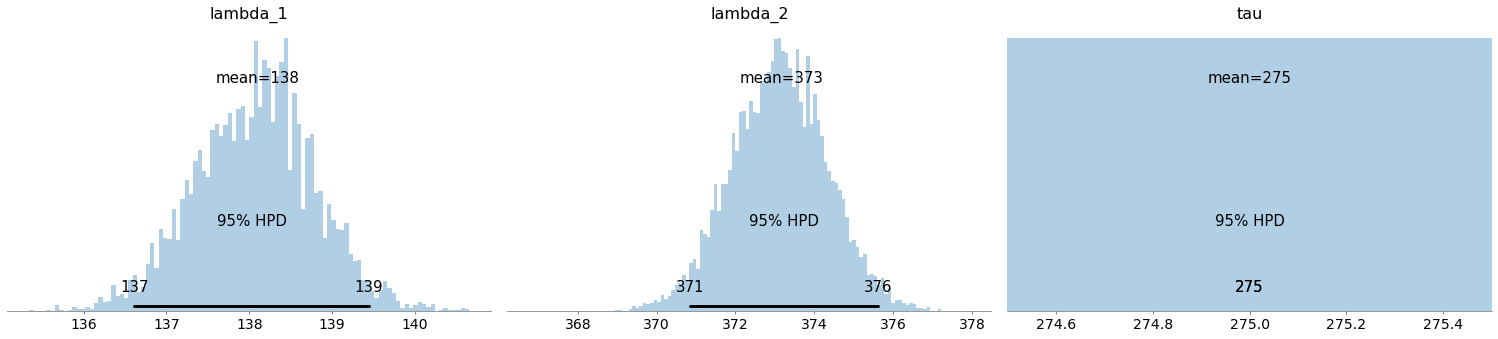

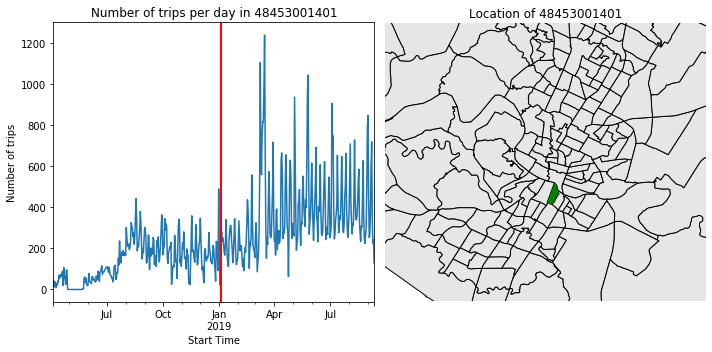

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:54<00:00, 1851.05draws/s]
The number of effective samples is smaller than 10% for some parameters.


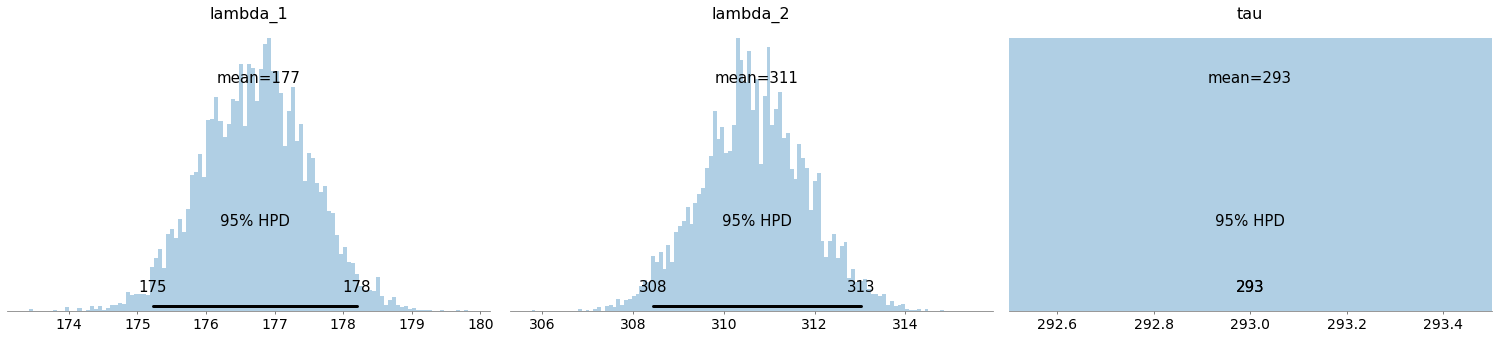

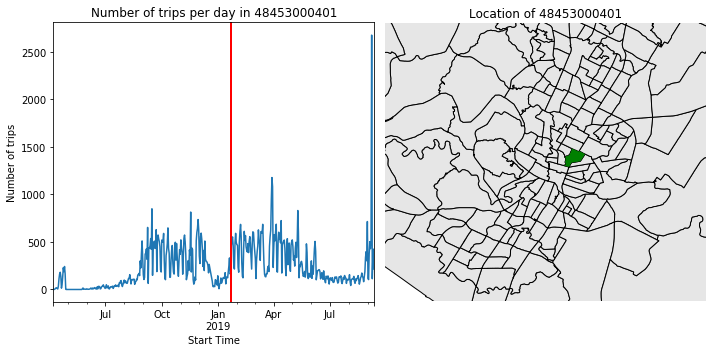

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:48<00:00, 2085.26draws/s]
The number of effective samples is smaller than 10% for some parameters.


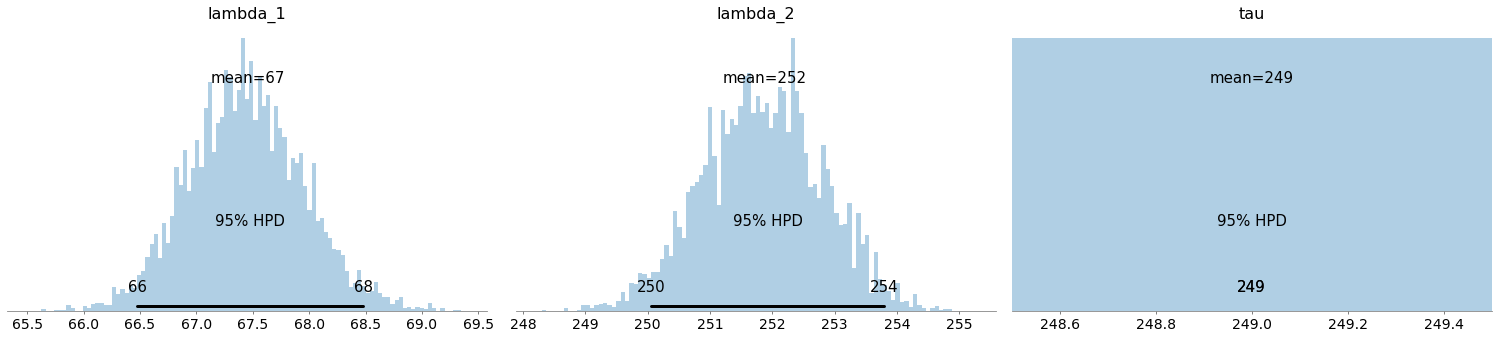

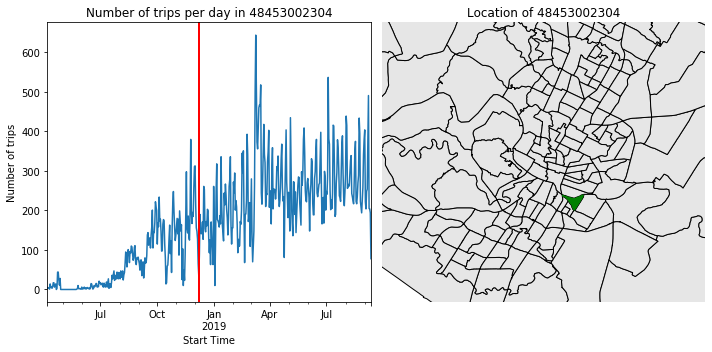

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:43<00:00, 2304.20draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


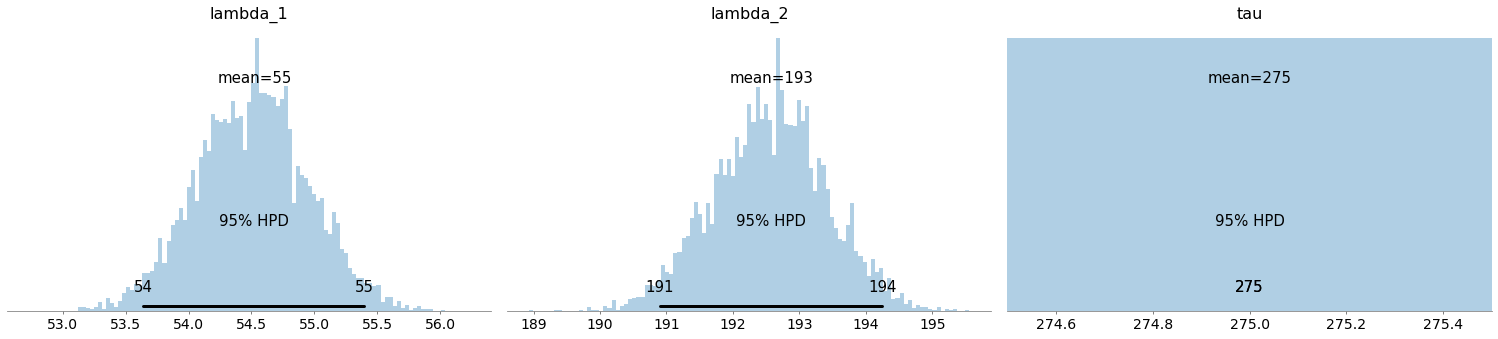

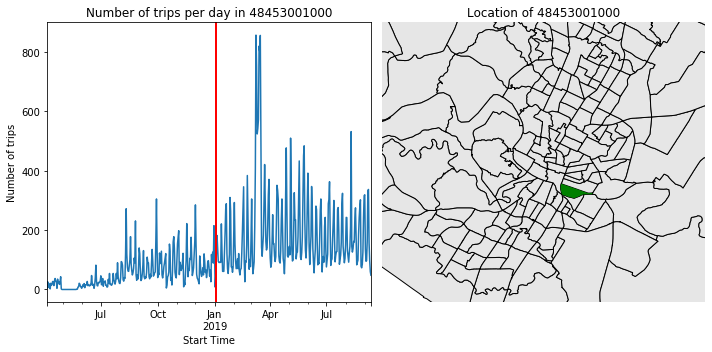

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:45<00:00, 2224.12draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/Users/trevor/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


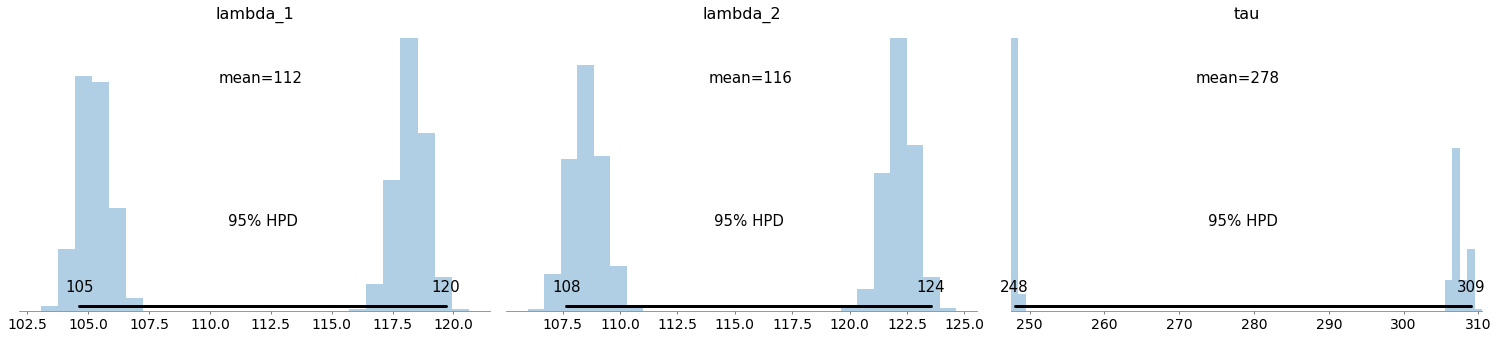

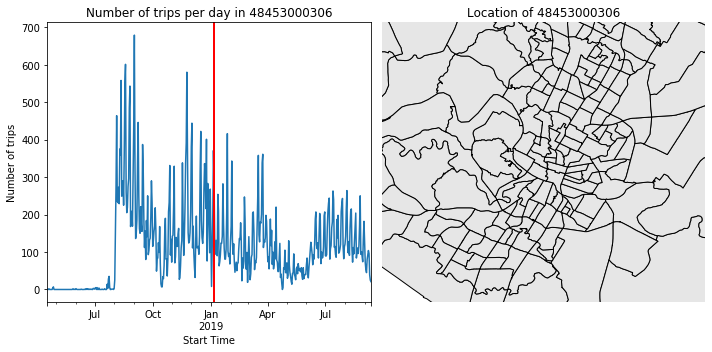

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:40<00:00, 2474.88draws/s]
The number of effective samples is smaller than 10% for some parameters.


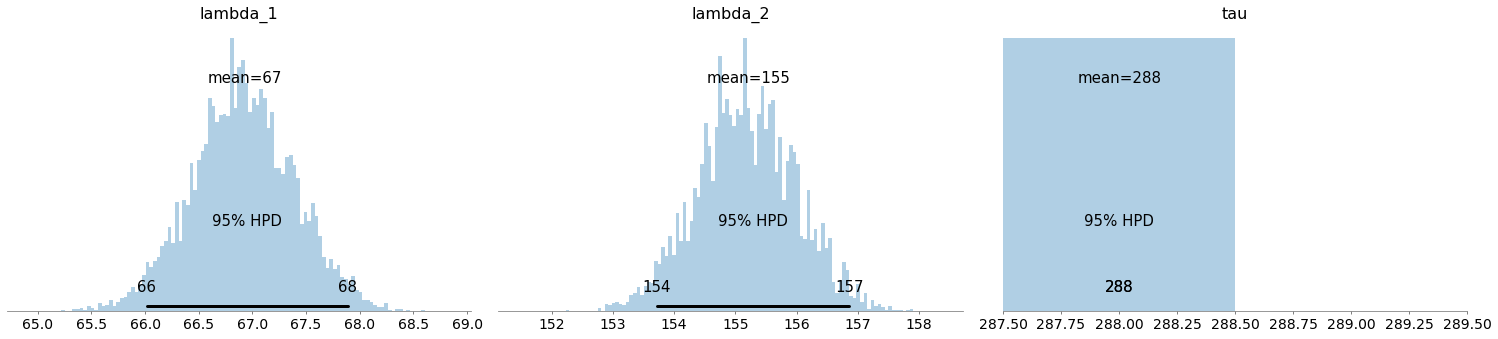

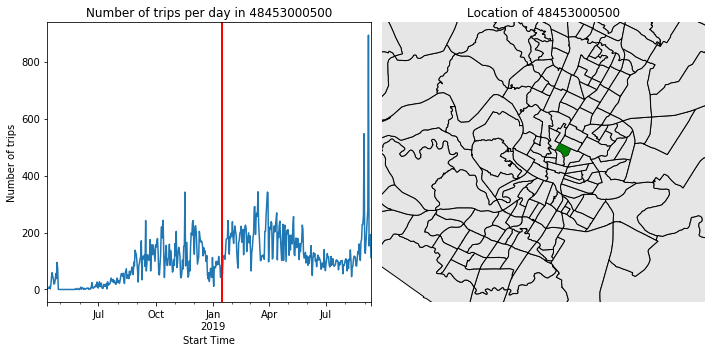

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:38<00:00, 2600.69draws/s]
The number of effective samples is smaller than 10% for some parameters.


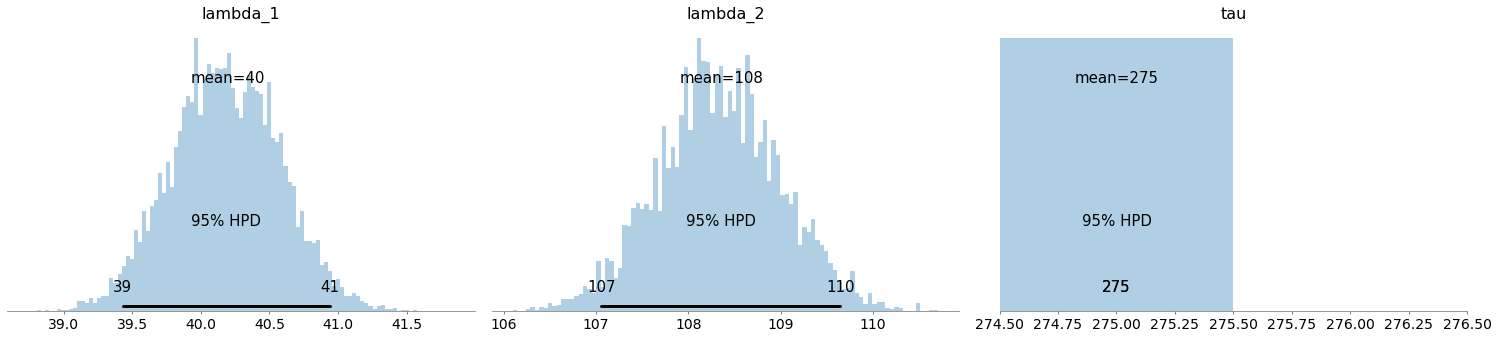

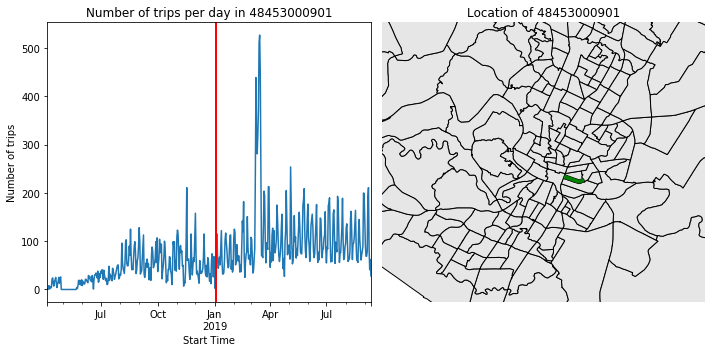

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:38<00:00, 2592.23draws/s]
The number of effective samples is smaller than 10% for some parameters.


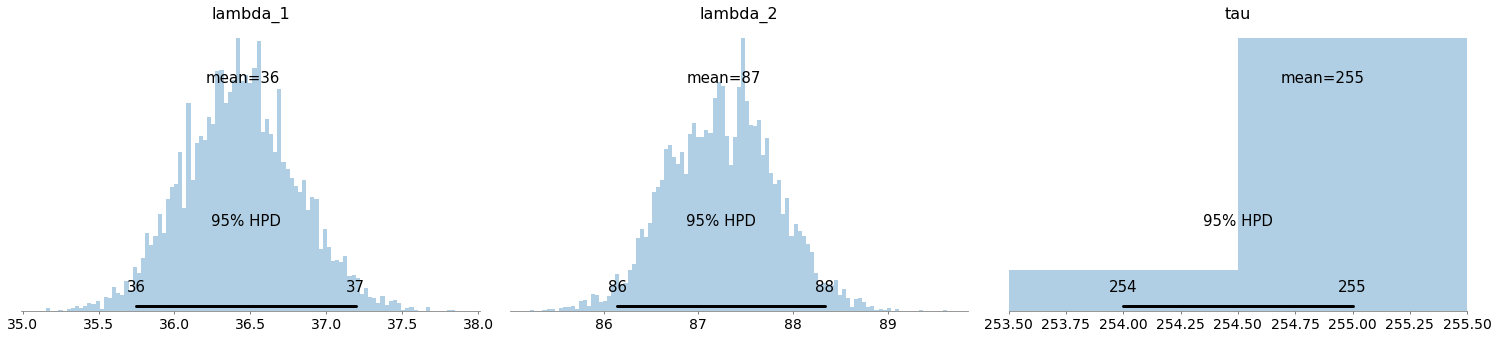

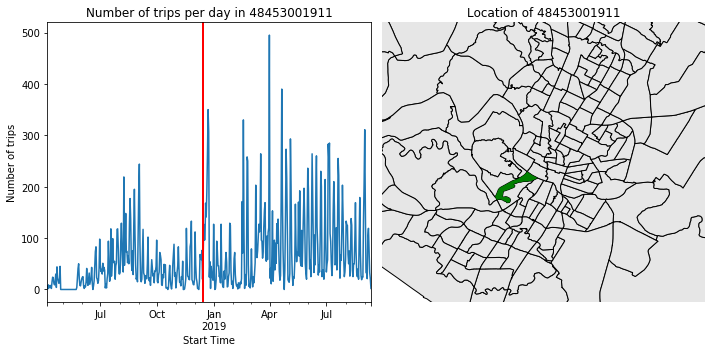

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:38<00:00, 2609.63draws/s]
The number of effective samples is smaller than 10% for some parameters.


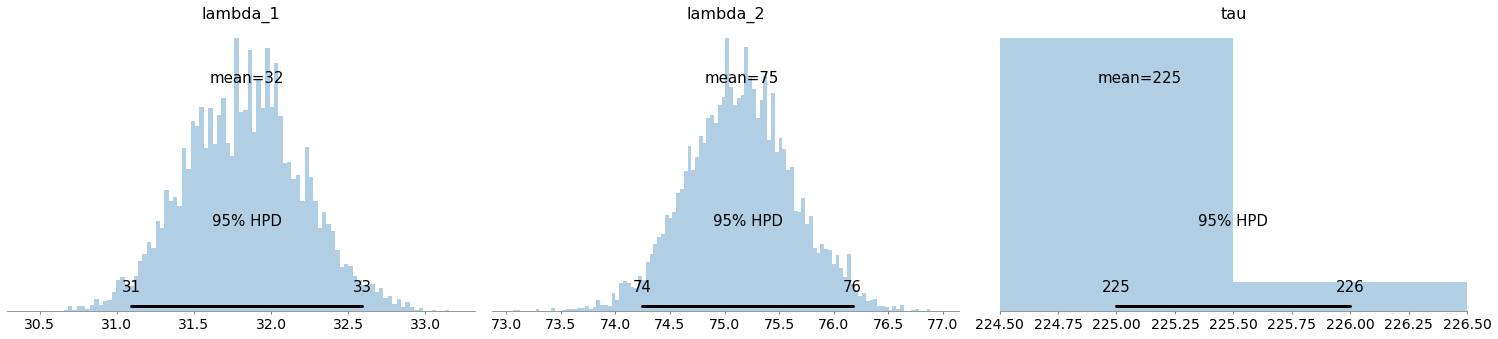

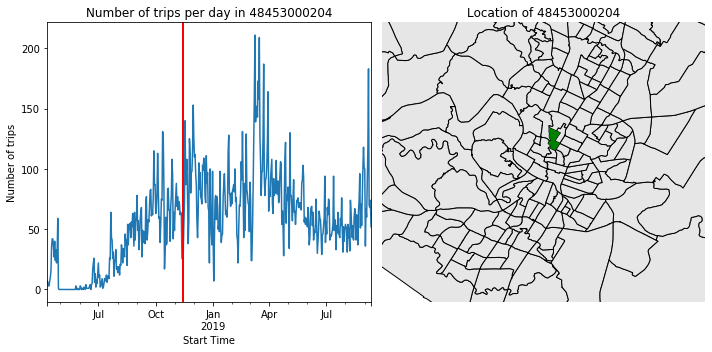

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:39<00:00, 2551.43draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


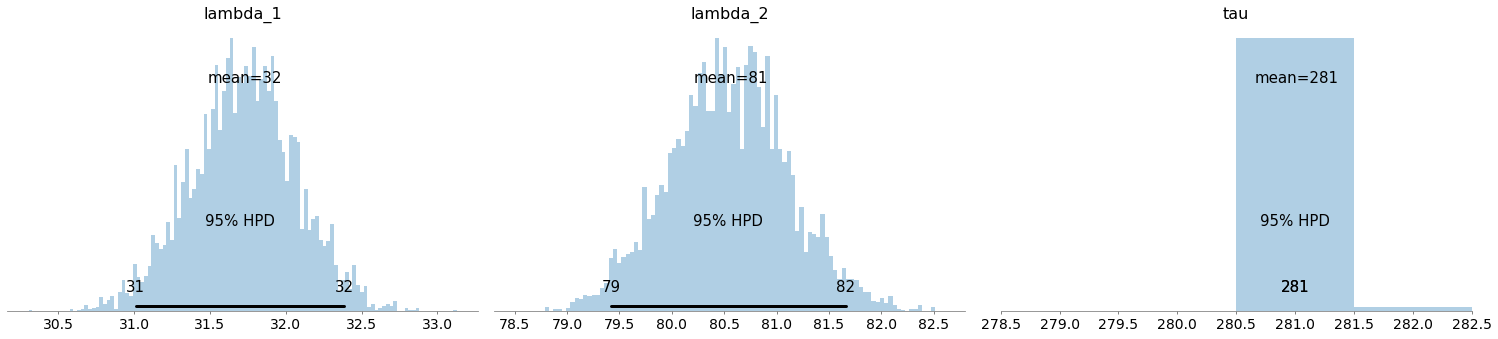

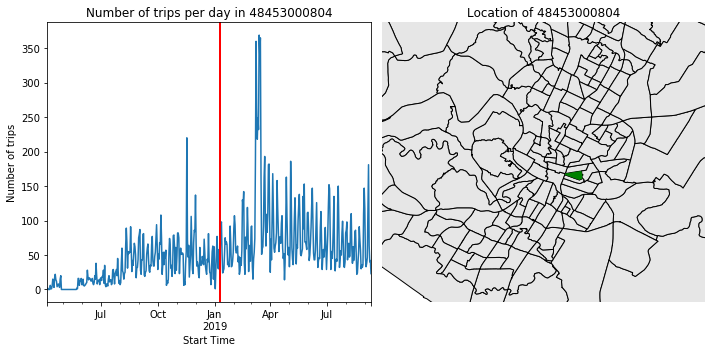

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:38<00:00, 2635.00draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


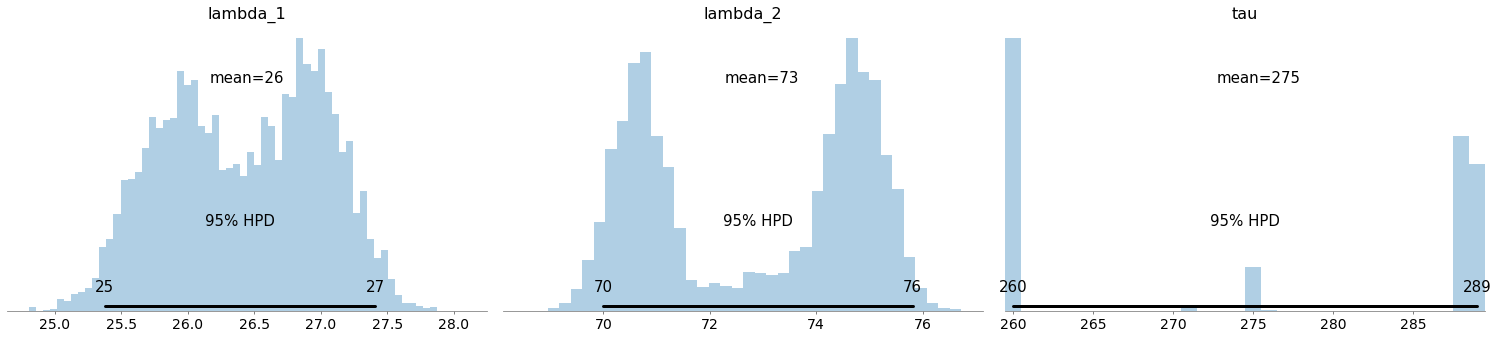

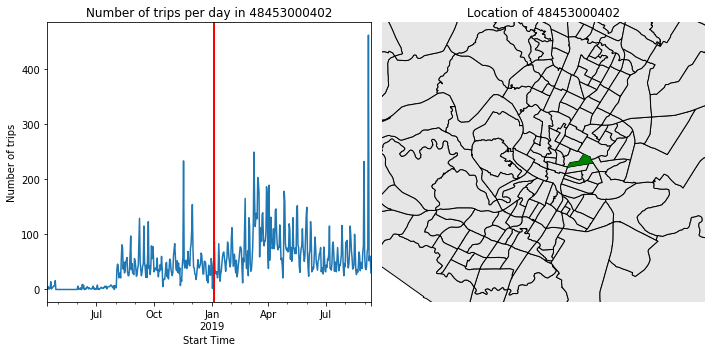

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:37<00:00, 2663.56draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


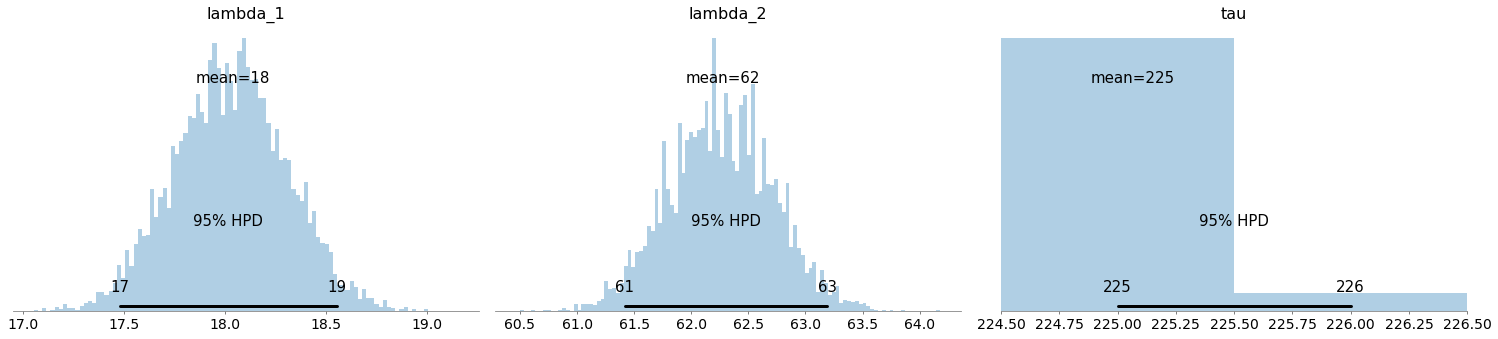

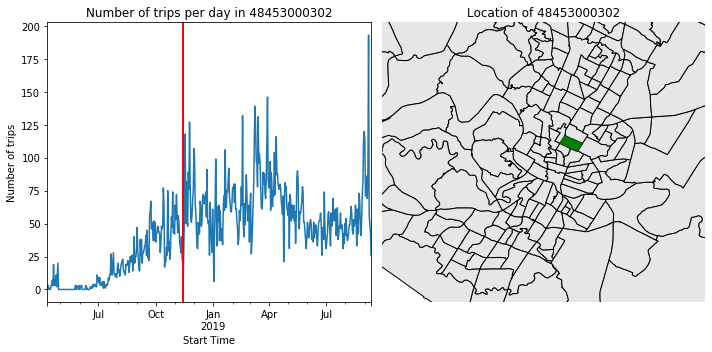

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:38<00:00, 2624.25draws/s]
The number of effective samples is smaller than 10% for some parameters.


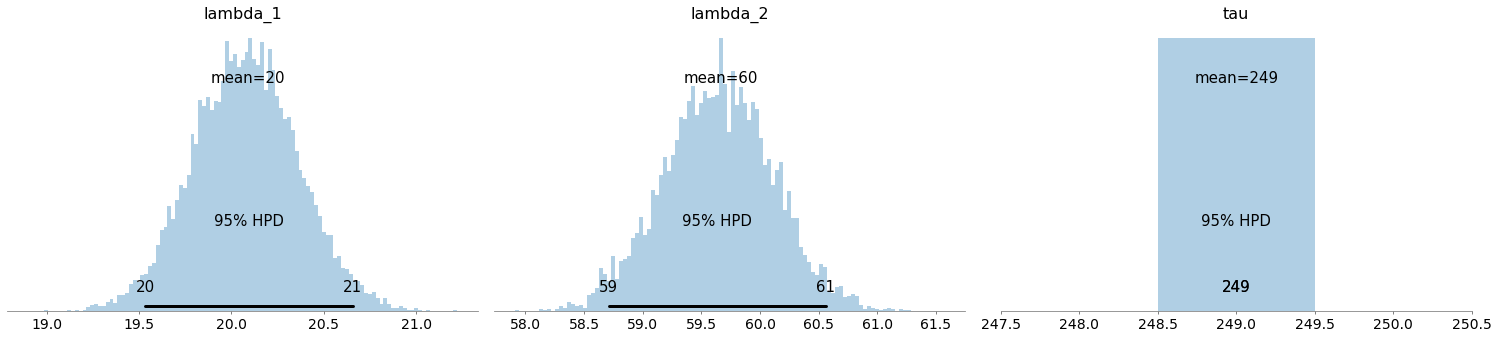

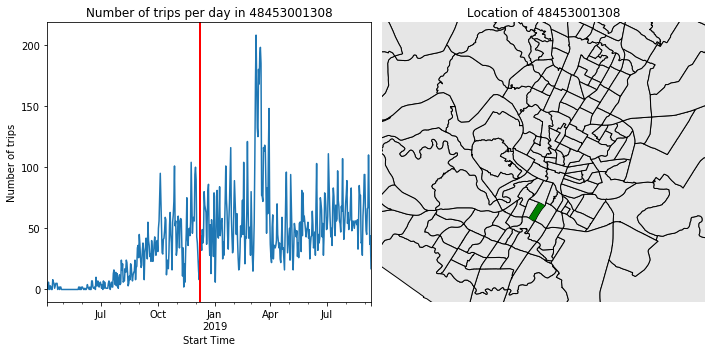

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:41<00:00, 2462.41draws/s]
The number of effective samples is smaller than 10% for some parameters.


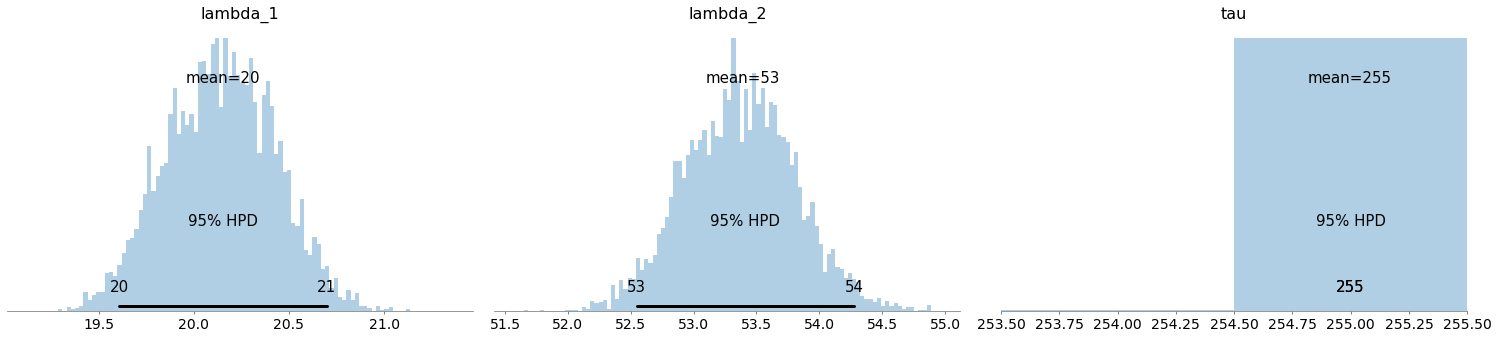

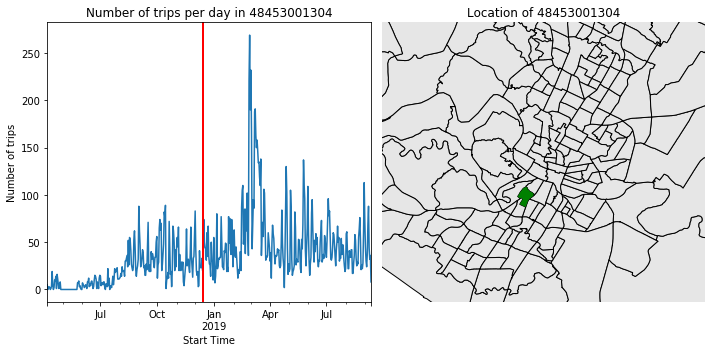

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:58<00:00, 1716.88draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


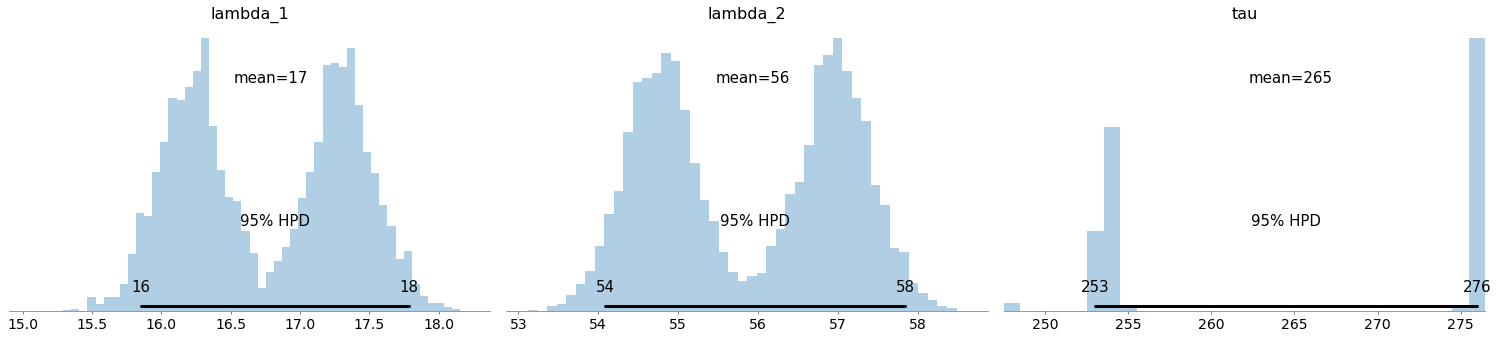

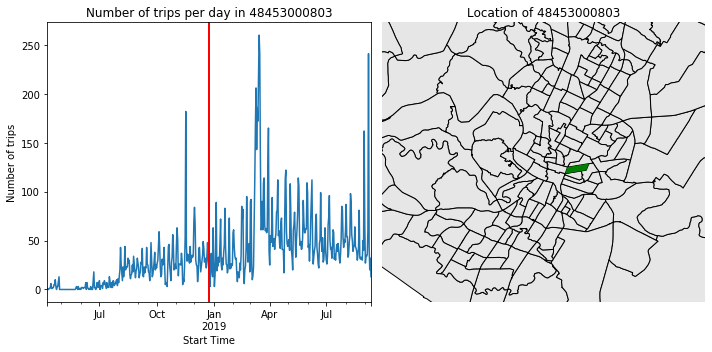

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:44<00:00, 2282.57draws/s]
The number of effective samples is smaller than 10% for some parameters.


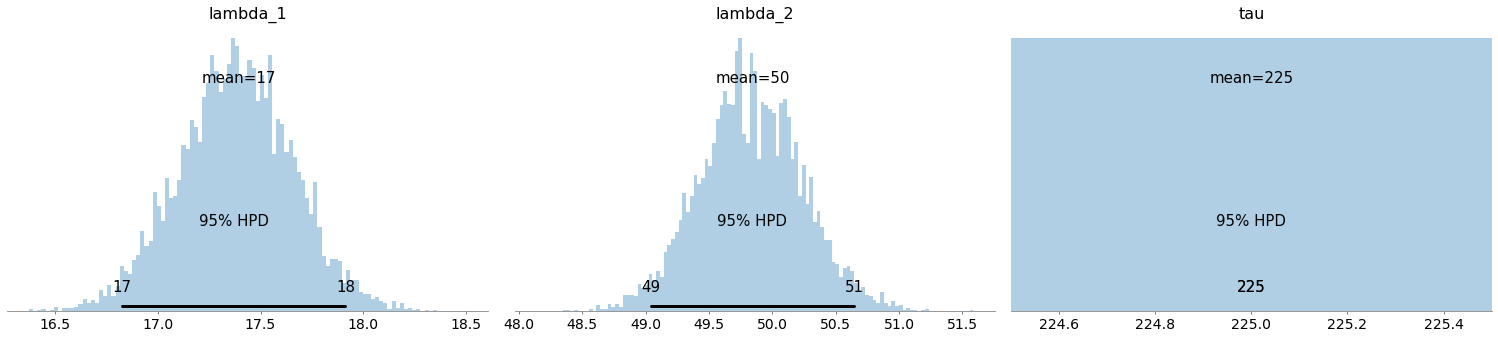

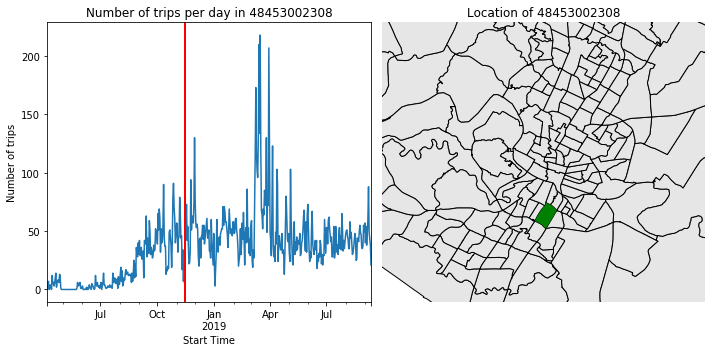

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:39<00:00, 2564.50draws/s]
The number of effective samples is smaller than 10% for some parameters.


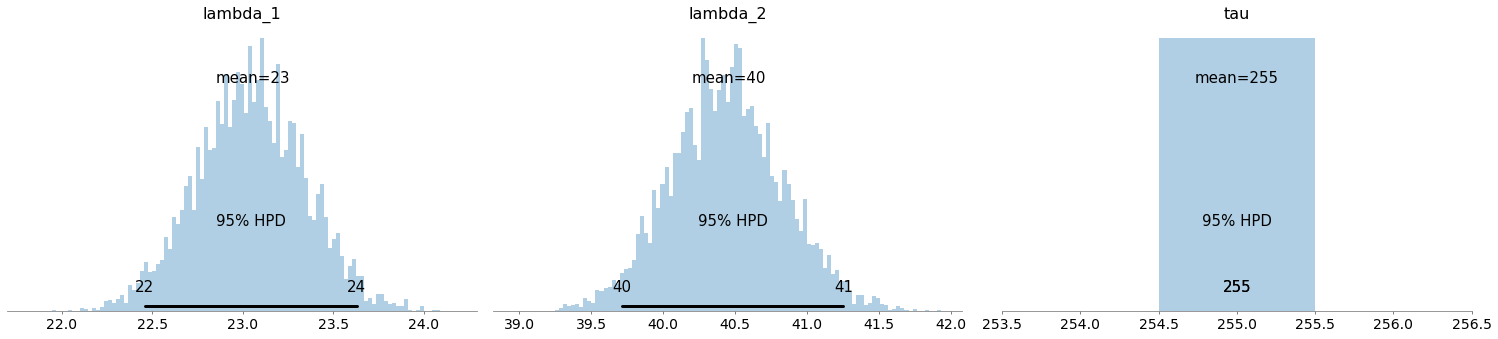

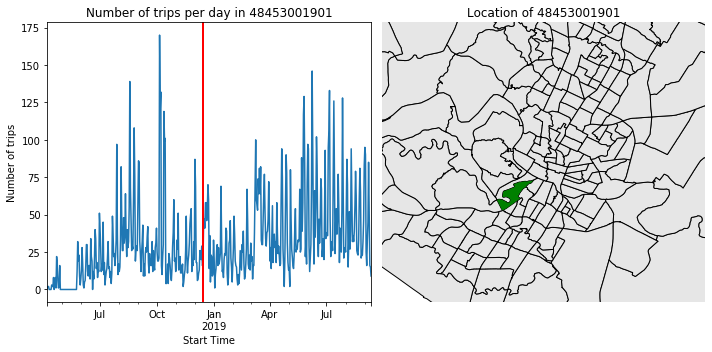

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:39<00:00, 2584.49draws/s]
The number of effective samples is smaller than 10% for some parameters.


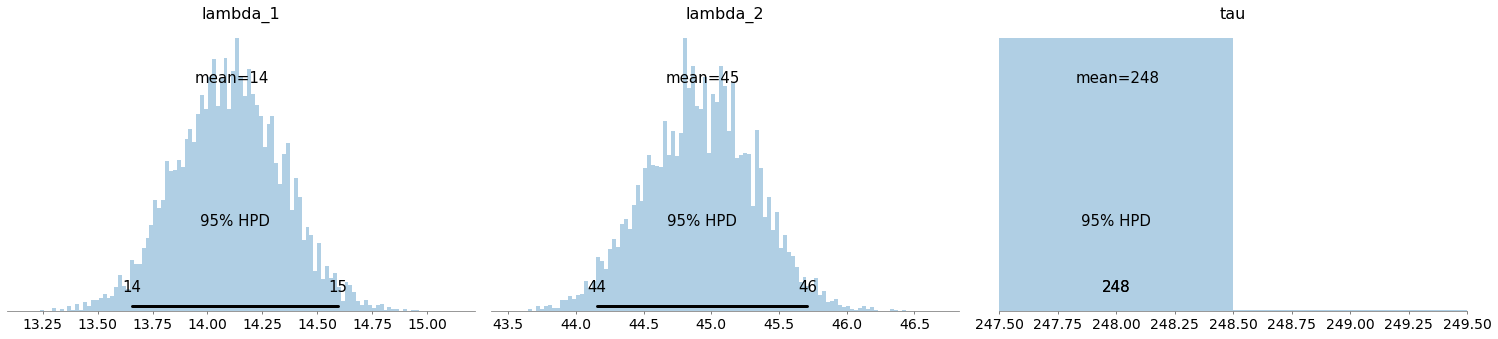

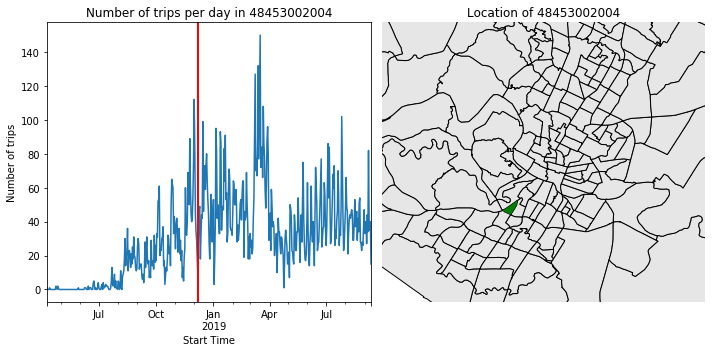

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:42<00:00, 2386.49draws/s]
The number of effective samples is smaller than 10% for some parameters.


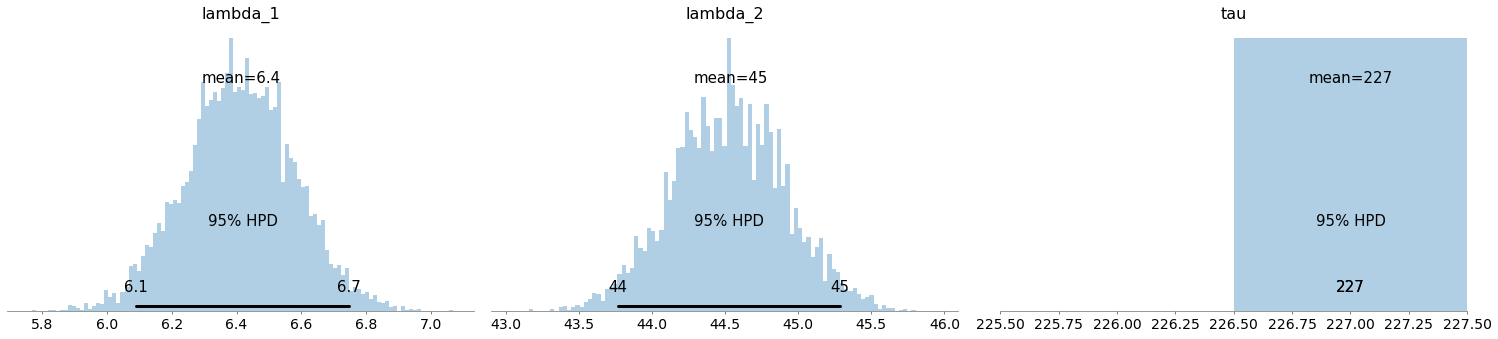

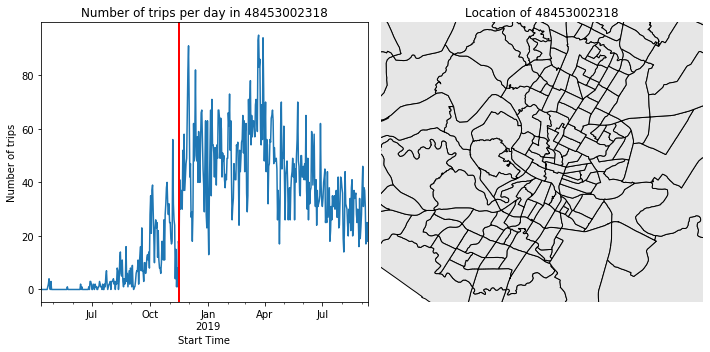

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains:   1%|          | 971/101000 [00:00<00:31, 3160.33draws/s]

In [ ]:
# initiate a dataframe for lambda_1, lambda_2, tau
mc_results = pd.DataFrame(columns=['Census Tract', 'lambda_1_mean', 'lambda_2_mean', 'tau_mean'])
mc_results['Census Tract'] = census_starts.index
mc_results = mc_results.set_index('Census Tract')

# # run analysis for 50 census tracts and save the results in a dataframe
for i, val in census_starts.head(50).iterrows():
    
    trace_i, lambda_1_i, lambda_2_i, tau_i = poisson_and_plot_cts(i)
    
    mc_results.loc[i]['lambda_1_mean'] = lambda_1_i
    mc_results.loc[i]['lambda_2_mean'] = lambda_2_i
    mc_results.loc[i]['tau_mean'] = tau_i

In [ ]:
# because the above cell takes so long to run, save the mc_results dataframe for future access.
# mc_results.to_csv('mc_results.csv')

In [ ]:
plt.figure(figsize=(8,10))

plt.subplot(3,1,1)
mc_results[mc_results['lambda_1_mean'] > 50]['lambda_1_mean'].plot(kind='bar')
plt.ylabel('Number of trips')
plt.title('$\lambda_1$ (greater than 50)')

plt.subplot(3,1,2)
mc_results[mc_results['lambda_2_mean'] > 50]['lambda_2_mean'].plot(kind='bar')
plt.ylabel('Number of trips')
plt.title('$\lambda_2$ (greater than 50)')

plt.subplot(3,1,3)
mc_results[mc_results['lambda_2_mean'] > 50]['tau_mean'].plot(kind='bar')
plt.ylabel('Day')
plt.title('tau')

plt.tight_layout()
plt.show()

In [ ]:
def weekly_average(census_tract):
    # Filter and resample for census tract
    trips = scooters[scooters['Census Tract Start'] == census_tract].resample('D', on='Start Time').count()

    # Keep just one column
    trips_df = trips['Device ID']

    # Group by day of week
    trips_df = trips_df.groupby(trips_df.index.weekday_name).mean()
    trips_df = trips_df.reset_index()

    # add a day of week number column to sort days of the week
    day_dict = {'Sunday': 0 , 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6}
    trips_df['weekday number'] = trips_df['Start Time'].map(day_dict)

    # reset index
    trips_df = trips_df.set_index('weekday number').sort_index()
    
    trips_df.plot(kind='bar', x='Start Time', y='Device ID')
    plt.show()
    plt.close()
    
    return trips_df


In [ ]:
weekly_average('48453001100')